In [8]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
palette = 'muted'
sns.set_palette(palette); sns.set_color_codes(palette)
import warnings
warnings.simplefilter('ignore')

In [5]:
def posterior_grid(grid_points, heads, tosses):
    grid = np.linspace(0, 1, grid_points)
    
    prior = np.repeat(5, grid_points)
    
    likelihood = stats.binom.pmf(heads, tosses, grid)
    
    unstd_posterior = likelihood * prior
    
    posterior = unstd_posterior / unstd_posterior.sum()
    
    return grid, posterior

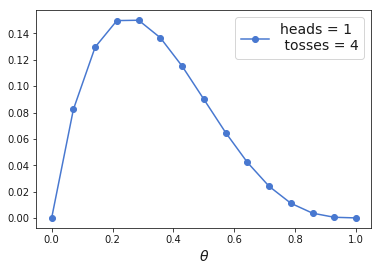

In [8]:
grid, posterior = posterior_grid(grid_points=15, heads=1, tosses=4)
plt.plot(grid, posterior, "-o", label=f"heads = {1}\n tosses = {4}")
plt.xlabel(r'$\theta$', fontsize=14)
plt.legend(loc=0, fontsize=14)

## MCMC

### Monte Carlo

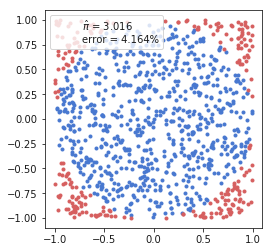

In [19]:
N = 1000
x, y = np.random.uniform(-1, 1, size=(2, N))
inside = (x**2 + y**2) <= 1
pi = inside.sum() * 4 / N
error = abs((pi - np.pi)/pi) * 100

outside = np.invert(inside)

plt.plot(x[inside], y[inside], "b.")
plt.plot(x[outside], y[outside], "r.")
plt.plot(0, 0, label='$\hat \pi$ = {:4.3f}\nerror = {:4.3f}%'.format(pi, error), alpha=0)
plt.axis("square")
plt.legend(loc='best')

### メトロポリス法

In [23]:
def metropolis(func, steps=10000):
    #init
    samples = np.zeros(steps)
    old_x = func.mean()
    old_prob = func.pdf(old_x)
    
    #sampling
    for i in range(steps):
        new_x = old_x + np.random.normal(0, 0.5)
        new_prob = func.pdf(new_x)
        acceptance = new_prob/old_prob
        if acceptance >= np.random.random():
            samples[i] = new_x
            old_x = new_x
            old_prob = new_prob
        else:
            samples[i] = old_x
    return samples

/Users/masamasakobakoba/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


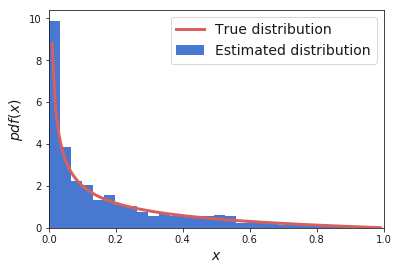

In [24]:
func = stats.beta(0.4, 2)
samples = metropolis(func=func)
x = np.linspace(0.01, 0.99, 100)
y = func.pdf(x)
plt.xlim(0, 1)
plt.plot(x, y, 'r-', lw=3, label='True distribution')
plt.hist(samples, bins=30, normed=True, label='Estimated distribution')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$pdf(x)$', fontsize=14)
plt.legend(fontsize=14)

# PyMC3

In [2]:
np.random.seed(123)
n_experiments = 4
theta_real = 0.35
data = stats.bernoulli.rvs(p=theta_real, size=n_experiments)
print(data)

[1 0 0 0]


In [10]:
with pm.Model() as our_first_model:
    ## modelの定義
    # a priori
    theta = pm.Beta("theta", alpha=1, beta=1)
    #likelihood
    y = pm.Bernoulli("y", p=theta, observed=data)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(1000, step=step, start=start)

logp = -2.7726, ||grad|| = 1: 100%|██████████| 6/6 [00:00<00:00, 1601.69it/s]
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:00<00:00, 10719.20draws/s]
The number of effective samples is smaller than 25% for some parameters.


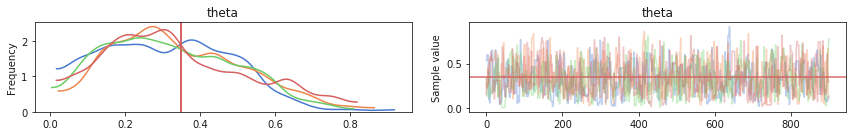

In [11]:
burnin = 100
chain = trace[burnin:]
pm.traceplot(chain, lines={"theta": theta_real});

In [12]:
pm.gelman_rubin(chain)

{'theta': 1.0024450329939345}

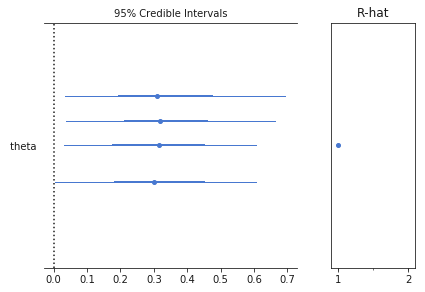

In [13]:
pm.forestplot(chain, varnames={"theta"})

In [14]:
pm.summary(chain)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta,0.329662,0.176724,0.006229,0.033146,0.660424,806.65579,1.002445


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x140d25b00>,
      dtype=object)

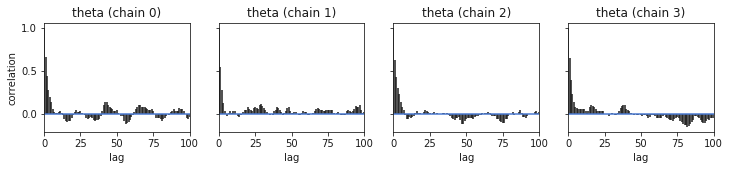

In [16]:
pm.autocorrplot(chain)

In [17]:
pm.effective_n(chain)

{'theta': 806.6557899691646}

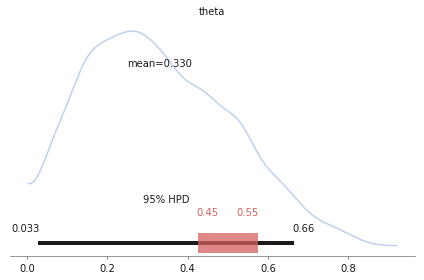

In [18]:
pm.plot_posterior(chain, kde_plot=True, rope=[0.45, 0.55])

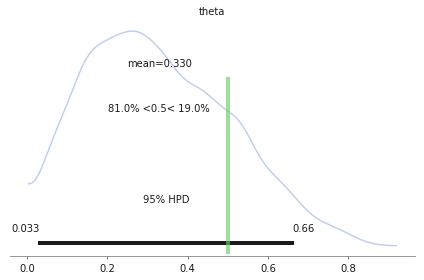

In [19]:
pm.plot_posterior(chain, kde_plot=True, ref_val=0.5)

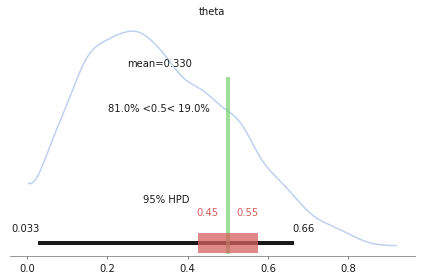

In [20]:
pm.plot_posterior(chain, kde_plot=True, rope=[0.45, 0.55], ref_val=0.5)